<center> <img alt="DAGsHub" width=500px src=https://raw.githubusercontent.com/DAGsHub/client/master/dagshub_github.png> </center>

# Tutoriel Stack Exchange - Analyse exploratoire des données (EDA)
Ce cahier est l'analyse des données utilisées dans le [tutoriel de DAGsHub](https://dagshub.com/docs/experiment-tutorial/overview/).

C'est ici principalement pour donner des explications et du code plus approfondis à ceux qui sont intéressés, et vous permet de modifier facilement le code et d'essayer différentes choses.

Si vous souhaitez simplement apprendre à utiliser DAGsHub, nous vous suggérons de lire le [tutoriel](https://dagshub.com/docs/experiment-tutorial/overview/), où nous [expliquons les parties importantes des résultats de cette EDA](https://dagshub.com/docs/tutorial/0-data), ainsi que :

* [Comment expérimenter différents modèles, prétraitement des données et ingénierie des fonctionnalités](https://dagshub.com/docs/experiment-tutorial/2-experiments/)
* Comment conserver les versions de vos données et de vos modèles, afin que toutes vos expériences soient automatiquement reproductibles - à déterminer - pour l'instant, consultez notre [Tutoriel de gestion des versions de données pour en savoir plus](https://dagshub.com/docs/tutorial/overview/)

In [ ]:
# IMPORTANT! Restart the runtine after running this cell once
!pip install --upgrade pandas-profiling==2.9.0
!pip install pandas-profiling==3.4.0

In [ ]:
!pip install --upgrade scikit-learn
!pip install -U scikit-learn==0.24

## Télécharger les données brutes
La source des données est l’API Cross Validated Stack Exchange.
C'est un tableau de questions.

Vous pouvez trouver la requête d'origine, jouer avec, obtenir des données mises à jour, etc. ici : https://data.stackexchange.com/stats/query/1290704/relevant-crossvalidated-posts-latest

Pour votre commodité et afin que vous obteniez des résultats cohérents avec le didacticiel, nous avons stocké ces données sur notre stockage cloud accessible au public.

In [2]:
!wget https://dagshub-public.s3.us-east-2.amazonaws.com/tutorials/stackexchange/CrossValidated-Questions-Nov-2020.csv -O CrossValidated-Questions.csv

--2024-03-26 17:04:57--  https://dagshub-public.s3.us-east-2.amazonaws.com/tutorials/stackexchange/CrossValidated-Questions-Nov-2020.csv
Resolving dagshub-public.s3.us-east-2.amazonaws.com (dagshub-public.s3.us-east-2.amazonaws.com)... 52.219.143.50, 52.219.92.82, 3.5.130.164, ...
Connecting to dagshub-public.s3.us-east-2.amazonaws.com (dagshub-public.s3.us-east-2.amazonaws.com)|52.219.143.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75856988 (72M) [text/csv]
Saving to: ‘CrossValidated-Questions.csv’

CrossValidated-Ques 100%[===================>]  72.34M  66.1MB/s    in 1.1s    

2024-03-26 17:04:58 (66.1 MB/s) - ‘CrossValidated-Questions.csv’ saved [75856988/75856988]



In [3]:
!ls -lah

total 73M
drwxr-xr-x 1 root root 4.0K Mar 26 17:04 .
drwxr-xr-x 1 root root 4.0K Mar 26 16:56 ..
drwxr-xr-x 4 root root 4.0K Mar 25 17:06 .config
-rw-r--r-- 1 root root  73M Nov 10  2020 CrossValidated-Questions.csv
drwxr-xr-x 1 root root 4.0K Mar 25 17:06 sample_data


## Charger les données pour le traitement
Puisqu'il s'agit d'un fichier CSV, nous pouvons le charger en utilisant [Pandas](https://pandas.pydata.org/) pour le traitement.

In [4]:
import pandas as pd
df = pd.read_csv('CrossValidated-Questions.csv')
df.head()

Id                                              Title  \
0  495508        Accepting null hypothesis given specificity   
1  495507  How do I calculate the probability of victory,...   
2  495506  Is joint modelling with survival and longitudi...   
3  495503    Are Spiking Neural Networks The Next Big Thing?   
4  495502  Public data and examples for practicing distri...   

                                                Body  \
0  <p>In a population of 10000 people, there is a...   
1  <p>If I have a poll of 600 people (standard de...   
2  <p>I would like to know if joint models for su...   
3  <p>Intel recently announced their Loihi chip a...   
4  <p>Are there public data for practicing distri...   

                                                Tags         CreationDate  \
0                                <bayesian><p-value>  2020-11-08 03:59:02   
1  <probability><normal-distribution><t-distribut...  2020-11-08 02:09:11   
2                             <survival><panel-data>  2020-11-08 01:55:08   
3  <machine-learning><neural-networks><sparse><ar...  2020-11-08 00:37:13   
4                             <references><learning>  2020-11-08 00:09:25   

   Score  ViewCount  AnswerCount  CommentCount  FavoriteCount  
0      0          5            0             2            NaN  
1      0         20            0             0            NaN  
2      0          5            0             0            NaN  
3      0         18            0             4            NaN  
4      1         10            0             3            1.0

Les colonnes sont assez explicites : nous avons :

* Deux fonctionnalités textuelles (`Titre` et `Corps`).

   On peut déjà dire que ce texte est en réalité rempli de balises HTML, qu'il faudra probablement nettoyer pour obtenir de bons résultats.
  
* Une colonne de chaîne qui est en fait la liste des « Tags » pour cette question. Celui-ci contient la balise cible « machine-learning » que nous voulons prédire.
* Quelques fonctionnalités numériques : `Score, ViewCount, AnswerCount, CommentCount, FavoriteCount`
* Une fonctionnalité `CreationDate` qui doit être traitée correctement :

In [5]:
df['CreationDate'] = pd.to_datetime(df['CreationDate'])
# Also include the numeric representation of the timestamp, so we can look at its distribution / correlation with other features
df['CreationDate_Epoch'] = df['CreationDate'].astype('int64') // 10 ** 9

N'oubliez pas non plus que notre objectif final ici est de **classer les questions sur l'apprentissage automatique**.
Ces informations sont stockées dans la colonne `Tags` :

In [6]:
df['MachineLearning'] = df['Tags'].str.contains('machine-learning').fillna(False)

Nous pouvons maintenant supprimer les colonnes non informatives

In [7]:
df = df.drop(columns=['Id','Tags'])

Quelques échantillons positifs et négatifs :

In [8]:
df[df['MachineLearning']].sample(5)

Title  \
40134  Why is "consistent nearest neighbour" Non-para...   
49918                      Checking if a kernel is valid   
44124  Train/test split that resembles original datas...   
834    Why is kernel SHAP only an estimation of the S...   
1088             On solving ode/pde with Neural Networks   

                                                    Body        CreationDate  \
40134  <p><strong>Definition of "Consistent nearest n... 2019-04-05 02:21:46   
49918  <p>The kernel is <span class="math-container">... 2018-10-13 00:27:25   
44124  <p>I'm modelling a continuous variable (say, t... 2019-01-30 21:47:06   
834    <p>In the paper <a href="https://papers.nips.c... 2020-10-28 11:51:18   
1088   <p>Recently, I watched this <a href="https://w... 2020-10-25 16:37:09   

       Score  ViewCount  AnswerCount  CommentCount  FavoriteCount  \
40134      1         22            0             5            0.0   
49918      1        191            1             5            NaN   
44124      5        811            2             3            NaN   
834        0         10            0             0            NaN   
1088       5        201            1            12            1.0   

       CreationDate_Epoch  MachineLearning  
40134          1554430906             True  
49918          1539390445             True  
44124          1548884826             True  
834            1603885878             True  
1088           1603643829             True

In [9]:
df[df['MachineLearning'] != True].sample(5)

Title  \
28004     Modify fit or function to match certain values   
27720                        Fleiss kappa vs Cohen kappa   
39015             Understanding the Cullen and Frey plot   
36534        Centering input data for Robust PCA (RPCA)?   
44672  Image Augmentation or incrementing dataset by ...   

                                                    Body        CreationDate  \
28004  <p>I have following values:</p>\n\n<pre><code>... 2019-11-19 09:18:42   
27720  <p>Can somebody explain in-detailed difference... 2019-11-22 06:27:23   
39015  <p>I would like to figure out which distributi... 2019-04-23 15:20:42   
36534  <p>I know that before running <a href="https:/... 2019-06-07 08:06:27   
44672  <p>My task is a regression task, where an inpu... 2019-01-22 09:58:00   

       Score  ViewCount  AnswerCount  CommentCount  FavoriteCount  \
28004      1         28            2             6            NaN   
27720      4       1068            1             0            NaN   
39015      6       3827            2             6            1.0   
36534      2         49            1             0            NaN   
44672      0         74            1             0            NaN   

       CreationDate_Epoch  MachineLearning  
28004          1574155122            False  
27720          1574404043            False  
39015          1556032842            False  
36534          1559894787            False  
44672          1548151080            False

We can define a new `Title_Len` and `Body_Len` column to get interesting statistics on question length

In [10]:
df['Title_Len'] = df.Title.str.len()
df['Body_Len'] = df.Body.str.len()

## Exploration des données
Essayons maintenant d'avoir une idée de la distribution des données. Nous commençons par une simple description des pandas sur toutes les colonnes.

In [11]:
df.describe(include='all')

<ipython-input-11-174ba9bf1a5c>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


Title  \
count                                             50000   
unique                                            49972   
top     K means clusters, would PCA be a better option?   
freq                                                  2   
first                                               NaN   
last                                                NaN   
mean                                                NaN   
std                                                 NaN   
min                                                 NaN   
25%                                                 NaN   
50%                                                 NaN   
75%                                                 NaN   
max                                                 NaN   

                                                     Body  \
count                                               50000   
unique                                              49987   
top     <p>Here is the link to the boy or girl paradox...   
freq                                                    2   
first                                                 NaN   
last                                                  NaN   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

               CreationDate         Score     ViewCount  AnswerCount  \
count                 50000  50000.000000  50000.000000  50000.00000   
unique                49974           NaN           NaN          NaN   
top     2018-11-07 11:05:52           NaN           NaN          NaN   
freq                      2           NaN           NaN          NaN   
first   2018-10-11 17:29:12           NaN           NaN          NaN   
last    2020-11-08 03:59:02           NaN           NaN          NaN   
mean                    NaN      1.121240    154.553100      0.67778   
std                     NaN      2.313259    616.019487      0.80392   
min                     NaN    -14.000000      1.000000      0.00000   
25%                     NaN      0.000000     23.000000      0.00000   
50%                     NaN      1.000000     42.000000      1.00000   
75%                     NaN      1.000000     97.000000      1.00000   
max                     NaN     87.000000  48969.000000     32.00000   

        CommentCount  FavoriteCount  CreationDate_Epoch MachineLearning  \
count   50000.000000    8918.000000        5.000000e+04           50000   
unique           NaN            NaN                 NaN               2   
top              NaN            NaN                 NaN           False   
freq             NaN            NaN                 NaN           44448   
first            NaN            NaN                 NaN             NaN   
last             NaN            NaN                 NaN             NaN   
mean        1.782800       1.366450        1.575066e+09             NaN   
std         2.551077       2.199443        1.878285e+07             NaN   
min         0.000000       0.000000        1.539279e+09             NaN   
25%         0.000000       1.000000        1.558326e+09             NaN   
50%         1.000000       1.000000        1.578066e+09             NaN   
75%         3.000000       1.000000        1.590782e+09             NaN   
max        34.000000      82.000000        1.604808e+09             NaN   

           Title_Len     Body_Len  
count   50000.000000  50000.00000  
unique           NaN          NaN  
top              NaN          NaN  
freq             NaN          NaN  
first            NaN          NaN  
last             NaN          NaN  
mean       63.073700   1336.45880  
std        25.075001

Il est également bon de savoir que nous n’avons pas besoin de gérer des valeurs nulles dans cet ensemble de données. Il semble prudent de supposer que les 82 % des lignes avec `FavoriteCount == null` peuvent être imputées à des zéros, ce qui signifie qu'aucun utilisateur n'a marqué ces questions comme favorites.

In [12]:
df.isnull().sum() * 100 / df.shape[0]

Title                  0.000
Body                   0.000
CreationDate           0.000
Score                  0.000
ViewCount              0.000
AnswerCount            0.000
CommentCount           0.000
FavoriteCount         82.164
CreationDate_Epoch     0.000
MachineLearning        0.000
Title_Len              0.000
Body_Len               0.000
dtype: float64

Nous utiliserons [Seaborn](https://seaborn.pydata.org/) pour visualiser les données. Il devrait être automatiquement disponible dans l'environnement Google Colab.

In [13]:
import seaborn as sns
sns.set()

Il semble qu'environ 11,1 % des données soient étiquetées comme `apprentissage automatique`.
Cela signifie qu’il s’agira d’un problème de classification déséquilibré, mais pas d’un déséquilibre catastrophique.

11.104% labeled True


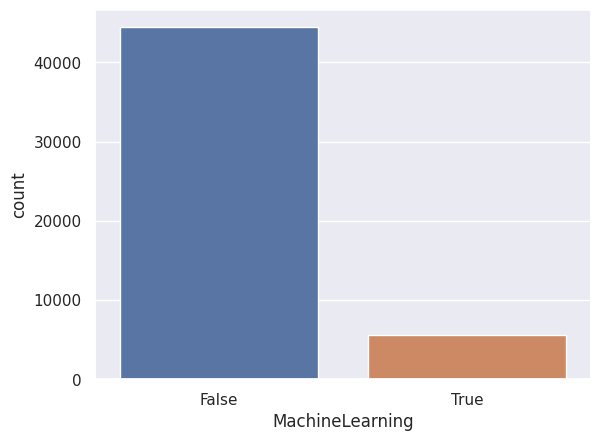

In [14]:
sns.countplot(x='MachineLearning', data=df, )
print(f"{df['MachineLearning'].mean() * 100}% labeled True")

Pour avoir une idée rapide de la distribution des données, nous pouvons utiliser [`pandas-profiling`](https://github.com/pandas-profiling/pandas-profiling).

Notez que la sortie est longue et défilable, alors assurez-vous de la faire défiler.

Voici quelques observations rapides de ce rapport :
* Nous devrions supprimer la colonne `FavoriteCount`, car elle est fortement corrélée avec `Score`
* `Score, ViewCount, AnswerCount` sont très asymétriques, nous pourrions donc en tenir compte dans la préparation des données.
* Notre label `MachineLearning` n'est pas trop fortement lié à une autre fonctionnalité unique.
* Le champ `CreationDate` est négativement corrélé avec la plupart des champs numériques, ce qui serait logique dans la mesure où les questions les plus récentes n'ont pas eu autant de temps pour recueillir des vues, des votes positifs et des réponses.
* `Body_Len` est négativement corrélé avec `AnswerCount`, ce qui est également logique - les gens sont probablement moins enclins à lire une longue question avant d'y répondre

Il y a probablement bien d’autres choses à apprendre de ce rapport, mais nous allons le laisser pour le moment. [Dans la prochaine partie du didacticiel](https://dagshub.com/docs/tutorial/1-experiments), nous utiliserons ce que nous avons appris sur les données pour les traiter pour les modèles de formation.

In [15]:
from pandas_profiling import ProfileReport
ProfileReport(df)

/usr/local/lib/python3.10/dist-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/usr/local/lib/python3.10/dist-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
# Drop the correlated features
df = df.drop(columns=['FavoriteCount'])

## Traitement des données

Tout d'abord, nous devons diviser les données en ensembles d'entraînement et de test.

Même avant de former le modèle lui-même, les étapes de prétraitement sont censées s'adapter uniquement aux données de formation, pas aux données de test.

In [17]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df)

Ici, nous essayons de mettre à l'échelle et de transformer les caractéristiques numériques pour les rendre plus fluides, moins asymétriques et plus appropriées pour la modélisation.

`PowerTransformer` tente de rendre les données plus proches d'une distribution normale, ce qui devrait atténuer l'impact des valeurs aberrantes extrêmes et rendre les distributions plus fluides.

`MinMaxScaler` est utilisé comme première étape pour s'assurer que les nombres se situent dans une plage raisonnable, car `PowerTransformer` peut échouer sur de très grands nombres.

In [18]:
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(MinMaxScaler(), PowerTransformer())
numeric_col_names = ['Title_Len','Body_Len','CreationDate_Epoch','AnswerCount','ViewCount','Score','CommentCount']
train_df_norm = pd.DataFrame(pipeline.fit_transform(train_df[numeric_col_names]), columns=numeric_col_names)
train_df_norm = train_df_norm.combine_first(train_df.reset_index()) # Add the other columns back

In [19]:
test_df_norm = pd.DataFrame(pipeline.transform(test_df[numeric_col_names]), columns=numeric_col_names)
test_df_norm = test_df_norm.combine_first(test_df.reset_index()) # Add the other columns back

En regardant la nouvelle répartition des fonctionnalités, nous pouvons voir qu'elles sont désormais correctement mises à l'échelle et moins asymétriques.

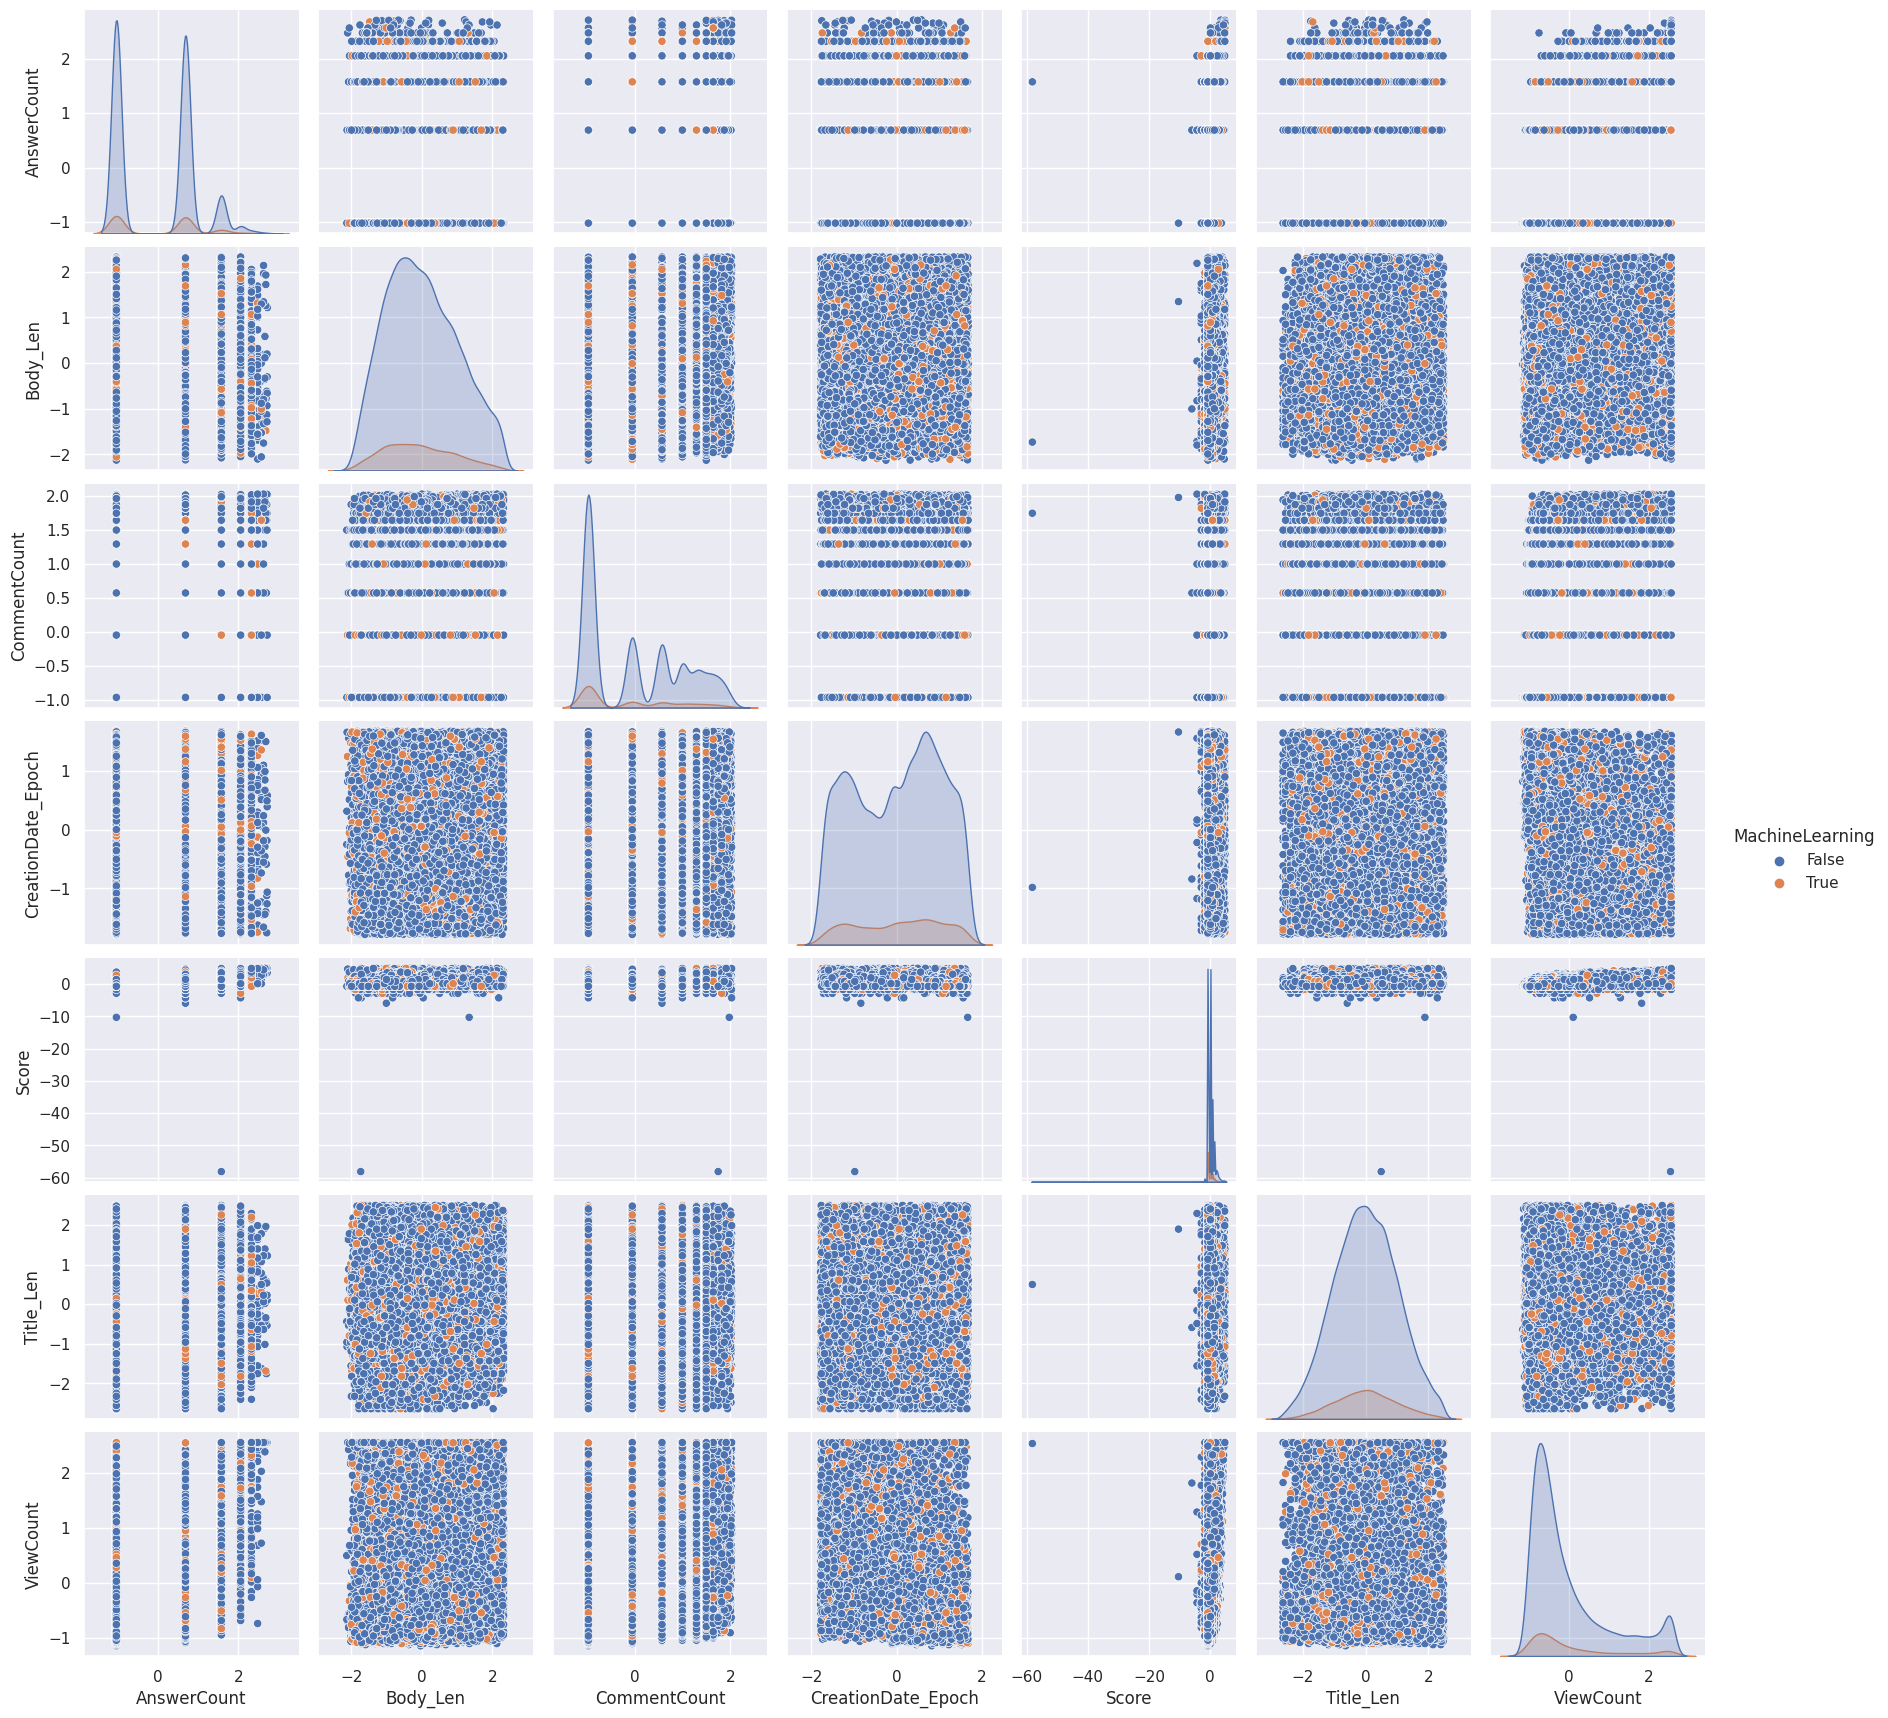

In [20]:
sns.pairplot(train_df_norm.drop(columns=['index','CreationDate']), hue='MachineLearning')

## Formation du modèle

Nous allons maintenant adapter un modèle de régression logistique de base à nos données, pour voir qu'il parvient à apprendre n'importe quoi. Nous n'essayons pas encore de l'optimiser, nous veillons simplement à ce qu'il apprenne avec succès quelque chose d'utile et que notre préparation des données nous ait aidé.

Pour le moment, nous n'utiliserons que les colonnes *numériques* pour ce modèle. Les colonnes textuelles nécessitent un prétraitement spécialisé avant de pouvoir être utilisées comme entrée dans un modèle.

Nous supprimerons la colonne `CreationDate`, car ses informations sont déjà stockées dans la colonne `CreationDate_Epoch` mise à l'échelle.

Pour avoir une bonne idée de la façon dont le modèle a appris quelque chose d'utile sur les données, nous réservons également certaines données pour les tests.

In [21]:
import sklearn.linear_model
clf = sklearn.linear_model.LogisticRegression()
train_cols = [c for c in numeric_col_names if c != 'CreationDate']
X = train_df_norm[train_cols]
y = train_df_norm['MachineLearning']
clf.fit(X, y)

LogisticRegression()

## Evaluation

Since we know that the classes are very imbalanced (only about 8% of the questions labeled as `machine-learning`), we'll avoid using the accuracy metric as an indication. Instead, we'll take a look at the precision-recall curve and ROC, which can tell us more useful information.

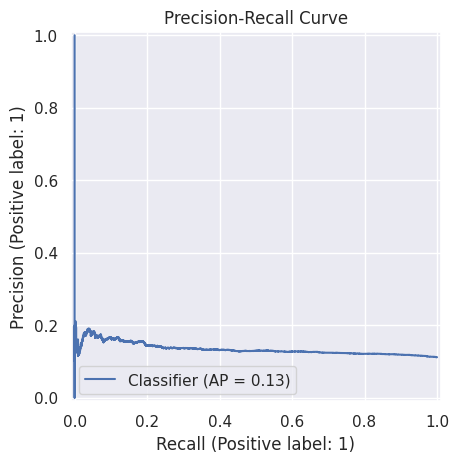

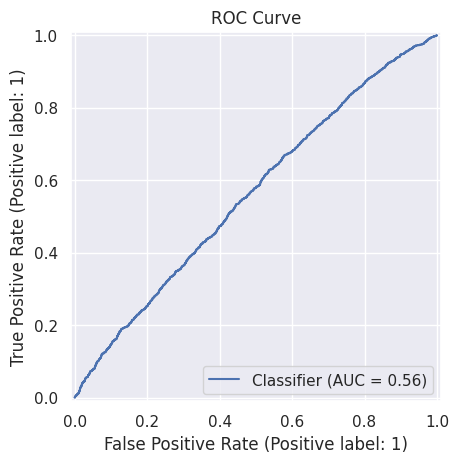

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

X_test = test_df_norm[train_cols]
y_test = test_df_norm['MachineLearning']

# Faire vos prédictions avec le modèle clf ici
y_pred = clf.predict_proba(X_test)[:, 1]

# Afficher la courbe précision-rappel
PrecisionRecallDisplay.from_predictions(y_test, y_pred)
plt.title('Precision-Recall Curve')

# Afficher la courbe ROC
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.title('ROC Curve')

plt.show()  # Afficher les graphiques


We can also look at the learned feature importances to understand what our model is looking for:

<AxesSubplot:>

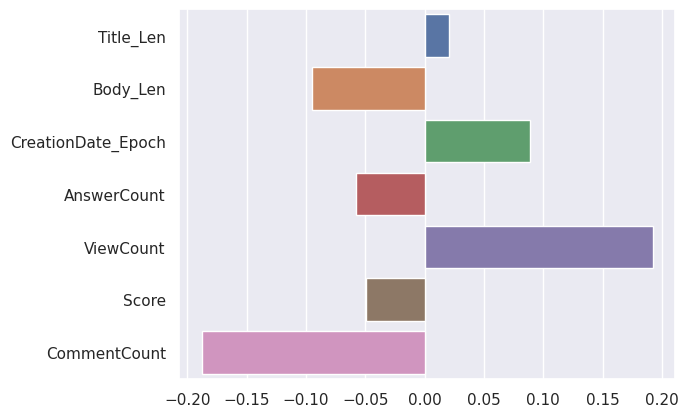

In [28]:
sns.barplot(y=train_cols, x=clf.coef_[0])

Looking at the following curves, we can see that the model really did learn useful information from the data, better than random at least.

Let's compare to a classifier trained on the unscaled data:

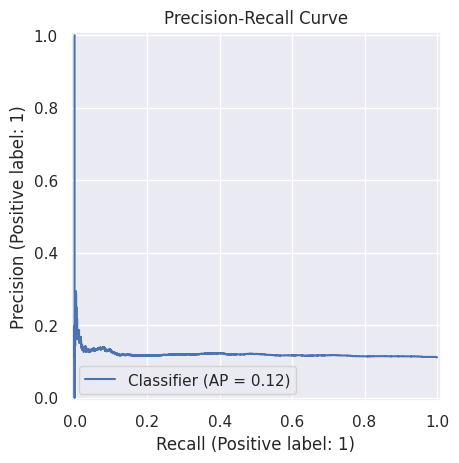

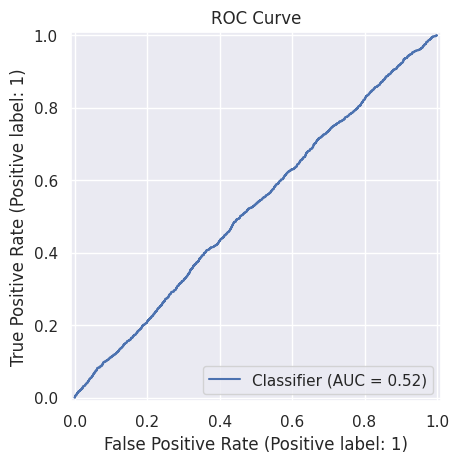

In [32]:

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

# Entrainement du modèle
clf_raw = LogisticRegression()
X_raw = train_df[train_cols]
y_raw = train_df['MachineLearning']
clf_raw.fit(X_raw, y_raw)

# Prédictions sur les données de test
X_test_raw = test_df[train_cols]
y_test_raw = test_df['MachineLearning']
y_pred_raw = clf_raw.predict_proba(X_test_raw)[:, 1]

# Affichage de la courbe précision-rappel
PrecisionRecallDisplay.from_predictions(y_test_raw, y_pred_raw)
plt.title('Precision-Recall Curve')

# Affichage de la courbe ROC
RocCurveDisplay.from_predictions(y_test_raw, y_pred_raw)
plt.title('ROC Curve')

plt.show()  # Afficher les graphiques

Clearly our data preprocessing helped - using the raw data yielded results that are even worse than random!

For sanity checking, let's compare it to a naive model, which always just guesses the common label:

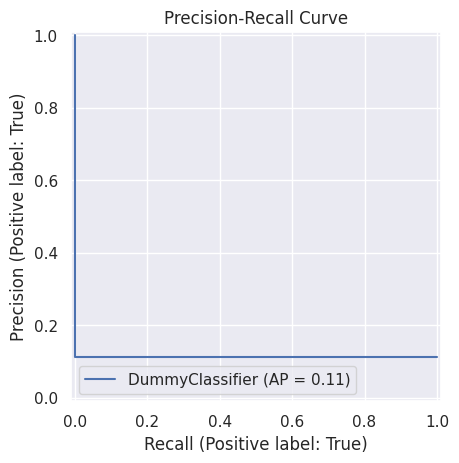

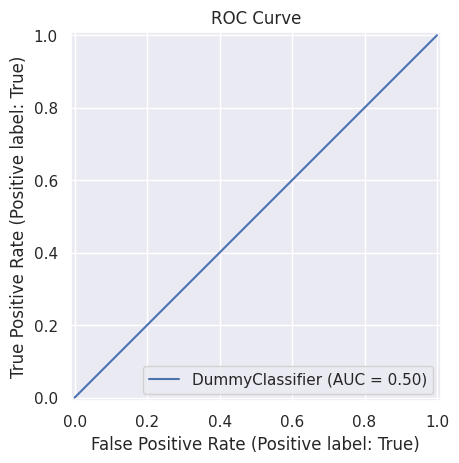

In [34]:
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

# Création et ajustement du modèle DummyClassifier
clf_dummy = DummyClassifier()
clf_dummy.fit(X, y)

# Affichage de la courbe de précision-rappel
disp_precision_recall = PrecisionRecallDisplay.from_estimator(clf_dummy, X_test, y_test)
disp_precision_recall.ax_.set_title('Precision-Recall Curve')

# Affichage de la courbe ROC
disp_roc_curve = RocCurveDisplay.from_estimator(clf_dummy, X_test, y_test)
disp_roc_curve.ax_.set_title('ROC Curve')

plt.show()  # Afficher les graphiques

## Textual Features

So, at this point we have a sense for our data, have found a good way to scale and normalze our *numeric* features, and have trained a very basic classifier on it.

The next phase would be to see what happens when we take advantage of our textual features - `Title` & `Body`. We'll use *only* the textual features to simplify things and isolate the effects.

To make things simple, we'll unify them into one big textual column.

In [35]:
train_text_col = train_df_norm['Title'].fillna('') + ' ' + train_df_norm['Body'].fillna('')
test_text_col = test_df_norm['Title'].fillna('') + ' ' + test_df_norm['Body'].fillna('')

To turn this text into numerical features that can be used as input to a ML model, we'll use [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) with a sensible limit of vocabulary size (`max_features=25000`). It will split the text into tokens, and give each question in the data a numerical representation of the frequency of tokens in that question.

Note that special care is needed when handling [sparse matrices in Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html), and the result returned from `TfidfVectorizer` is a sparse matrix. **If you ignore this special handling, expect to run into out-of-memory errors, unresponsiveness and crashes as the sparse matrix gets inflated.**

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Création de l'objet TfidfVectorizer
tfidf = TfidfVectorizer(max_features=25000)

# Ajustement sur les données d'entraînement et transformation en DataFrame
train_tfidf_matrix = tfidf.fit_transform(train_text_col)
train_tfidf_df = pd.DataFrame.sparse.from_spmatrix(train_tfidf_matrix, columns=tfidf.get_feature_names_out())

# Transformation des données de test en DataFrame en utilisant le même TfidfVectorizer
test_tfidf_matrix = tfidf.transform(test_text_col)
test_tfidf_df = pd.DataFrame.sparse.from_spmatrix(test_tfidf_matrix, columns=tfidf.get_feature_names_out())

**Interesting notes:** Looks like many of the learned terms are:
* Various numbers, like `00`, `00000000e` etc. It could be useful to prevent this splitting of numbers into many different terms in the vocabulary, since it probably won't matter to classifying the text.
* Multiple terms grouped together due to an underscore, like `variable_2`. This is probably an artifact of embedded Python or TeX code. It might help the model if we break these down to separate terms.
* Remember, the questions contain embedded HTML. While we're not seeing any terms that were clearly garbage created by HTML, it's a good bet that it will be useful to clean up the HTML tags in the text.

In [38]:
train_tfidf_df.sample(15, axis=1)

clase  3800  last_draw  absorption  mcculloch  485       has  \
0        0.0   0.0        0.0         0.0        0.0  0.0  0.000000   
1        0.0   0.0        0.0         0.0        0.0  0.0  0.029268   
2        0.0   0.0        0.0         0.0        0.0  0.0  0.000000   
3        0.0   0.0        0.0         0.0        0.0  0.0  0.000000   
4        0.0   0.0        0.0         0.0        0.0  0.0  0.059626   
...      ...   ...        ...         ...        ...  ...       ...   
37495    0.0   0.0        0.0         0.0        0.0  0.0  0.000000   
37496    0.0   0.0        0.0         0.0        0.0  0.0  0.000000   
37497    0.0   0.0        0.0         0.0        0.0  0.0  0.000000   
37498    0.0   0.0        0.0         0.0        0.0  0.0  0.000000   
37499    0.0   0.0        0.0         0.0        0.0  0.0  0.076836   

       riverkm_perkm2  64658635    among  v_t  sewer  rms  pi_1  berkeley  
0                 0.0       0.0  0.10963  0.0    0.0  0.0   0.0       0.0  
1                 0.0       0.0  0.00000  0.0    0.0  0.0   0.0       0.0  
2                 0.0       0.0  0.00000  0.0    0.0  0.0   0.0       0.0  
3                 0.0       0.0  0.00000  0.0    0.0  0.0   0.0       0.0  
4                 0.0       0.0  0.00000  0.0    0.0  0.0   0.0       0.0  
...               ...       ...      ...  ...    ...  ...   ...       ...  
37495             0.0       0.0  0.00000  0.0    0.0  0.0   0.0       0.0  
37496             0.0       0.0  0.00000  0.0    0.0  0.0   0.0       0.0  
37497             0.0       0.0  0.00000  0.0    0.0  0.0   0.0       0.0  
37498             0.0       0.0  0.00000  0.0    0.0  0.0   0.0       0.0  
37499             0.0       0.0  0.00000  0.0    0.0  0.0   0.0       0.0  

[37500 rows x 15 columns]

In [39]:
clf_tfidf = sklearn.linear_model.LogisticRegression()
clf_tfidf.fit(train_tfidf_df.sparse.to_coo(), y)

LogisticRegression()

## Evaluating the textual model
Below, we can see that the new text-based model performs stunningly well!

This is not surprising, as most information will be contained in the text content of each question.

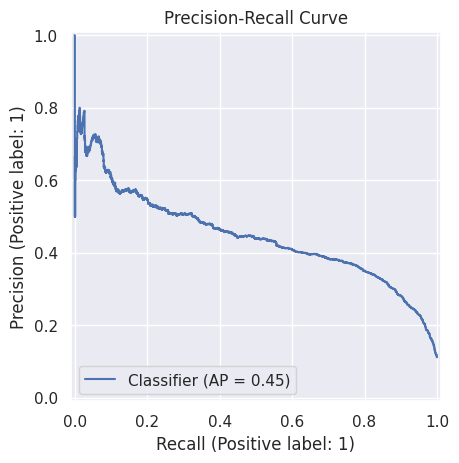

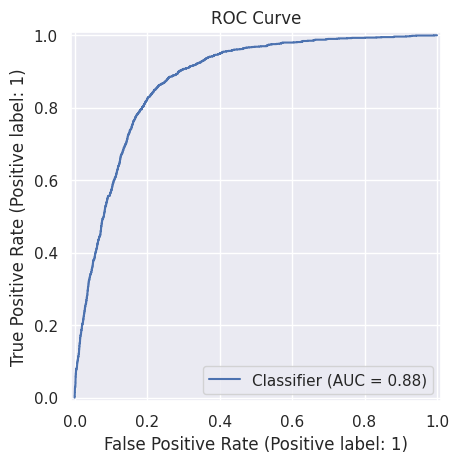

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

# X_tfidf_test contient votre matrice creuse transformée à partir des données de test
X_tfidf_test = test_tfidf_matrix

# clf_tfidf est votre modèle entraîné avec les données d'entraînement
# Assurez-vous que clf_tfidf est déjà entraîné avant d'exécuter ces lignes de code
# Par exemple, clf_tfidf.fit(X_tfidf_train, y_train)

# Prédictions sur les données de test
y_pred_tfidf = clf_tfidf.predict_proba(X_tfidf_test)[:, 1]

# Affichage de la courbe précision-rappel
PrecisionRecallDisplay.from_predictions(y_test, y_pred_tfidf)
plt.title('Precision-Recall Curve')

# Affichage de la courbe ROC
RocCurveDisplay.from_predictions(y_test, y_pred_tfidf)
plt.title('ROC Curve')

plt.show()  # Afficher les graphiques

As a sanity check, it's a good idea to check what terms the textual model cares about when making its decision.

As we see below, it looks like our model learned some very good, sensible terms, that we would have probably guessed on our own, such as `machine`, `learning`, `classifier`, etc.

It's interesting to note that `analysis` is a *negative*  predictor for a question about machine learning, as opposed to a general statistical question. Just throw a neural network at it 😅

<AxesSubplot:xlabel='coef', ylabel='term'>

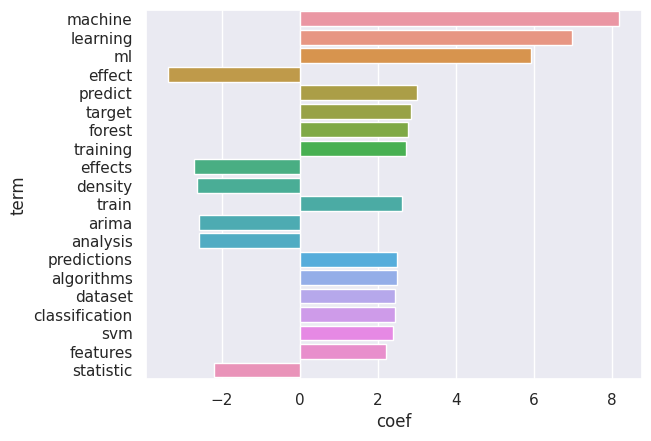

In [41]:
tfidf_coef_df = pd.DataFrame({'coef':clf_tfidf.coef_[0]})
tfidf_coef_df['term'] = tfidf.get_feature_names_out()
tfidf_coef_df['coef_abs'] = tfidf_coef_df['coef'].abs()
tfidf_coef_df = tfidf_coef_df.sort_values('coef_abs', ascending=False)
sns.barplot(y='term', x='coef', data=tfidf_coef_df[:20])

[![Stack More Layers](https://stackmorelayers.be/bg.png)](https://stackmorelayers.be)

# Conclusion

We got a good sense of our data, the type of preprocessing required, and managed to train some decent classifiers with it.

At this point in a Python data science project, it's common to take the conclusions and working code from the exploratory notebook, and turn them into normal Python modules. This enables us to more easily:
* Create reusable components that will be useful as the project matures.
* Use code versioning tools like Git.
* Make the process more reproducible by defining a clear pipeline (order of operations) for the data and model training.
* Automate running and tracking of experiments.
* Version our different experiments and models, so that we preserve knowledge and don't risk losing work by accident.

[In the next level of DAGsHub's tutorial](https://dagshub.com/docs/experiment-tutorial/1-setup/), we'll take what works from this notebook and turn it into a Python project, before [going forward with experimentation](https://dagshub.com/docs/experiment-tutorial/2-experiments/) to find the best performing model for out problem.

Made with 🐶 by [DAGsHub](https://dagshub.com).